In [95]:
import re

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from matplotlib.pyplot import figure
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



### **Data Preprocessing**

In [96]:
# read the dataset file
df = pd.read_csv('./ckd-dataset-v2.csv')

# check the top 5 rows of dataframe
df.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,...,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete,discrete
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,class,meta
2,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
3,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
4,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12


In [97]:
# as we can see row 0 and 1 contain garbadge values so we can delete these two rows
df.drop([0,1],axis=0,inplace=True)

# reset the index after droping row 1 and 2
df = df.reset_index(drop=True)

# again check the top 5 extries 
df.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,0,0,1.019 - 1.021,1 - 1,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
1,0,0,1.009 - 1.011,< 0,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,≥ 227.944,s1,1,< 12
2,0,0,1.009 - 1.011,≥ 4,ckd,1,< 0,1,0,1,...,0,0,0,1,0,0,127.281 - 152.446,s1,1,< 12
3,1,1,1.009 - 1.011,3 - 3,ckd,0,< 0,0,0,0,...,0,0,0,0,0,0,127.281 - 152.446,s1,1,< 12
4,0,0,1.015 - 1.017,< 0,ckd,0,< 0,0,0,0,...,0,1,0,1,1,0,127.281 - 152.446,s1,1,12 - 20


In [98]:
# convert the categories of target ("ckd", "notckd") to (1, 0) 
df['class'] = df['class'].map({'ckd': 1, 'notckd': 0})

1    128
0     72
Name: class, dtype: int64


<AxesSubplot: >

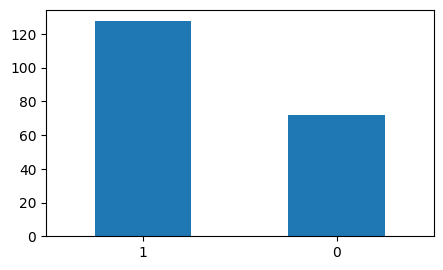

In [99]:
# Check for class imballance problem
print(df['class'].value_counts())

figure(figsize=(5, 3), dpi=100)
df['class'].value_counts().plot.bar(rot=0)

In [100]:
df['stage'] = df['stage'].map({'s1': 1, 's2': 2, 's3': 3, 's4': 4, 's5': 5})

In [101]:
#Removed all unnecessary whitespaces 
#Found average of values given in range
#Addded 1 after removing '>', Subtracted 1 after removing '<' and kept the first value when values are given in range like "3-6" and the original value when there was '≥' 



regexp = re.compile(r'≥|≤')

df = df.applymap(lambda x: str(x).replace(' ','') if ' ' in str(x) else x)
df = df.applymap(lambda x: (float(str(x).split('-')[0])+float(str(x).split('-')[1]))/2 if '-' in str(x) else x) 
df = df.applymap(lambda x: float(x[1:])-1 if '<' in str(x) else (str(x).replace('≥','').replace('≤','') if regexp.search(str(x)) else(float(x[1:])+1 if '>' in str(x) else x )))


df.head()

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
0,0,0,1.02,1.0,1,0,-1.0,0,0,0,...,0,0,0,0,0,0,227.944,1,1,11.0
1,0,0,1.01,-1.0,1,0,-1.0,0,0,0,...,0,0,0,0,0,0,227.944,1,1,11.0
2,0,0,1.01,4,1,1,-1.0,1,0,1,...,0,0,0,1,0,0,139.8635,1,1,11.0
3,1,1,1.01,3.0,1,0,-1.0,0,0,0,...,0,0,0,0,0,0,139.8635,1,1,11.0
4,0,0,1.016,-1.0,1,0,-1.0,0,0,0,...,0,1,0,1,1,0,139.8635,1,1,16.0


In [102]:
# fix the string present in column: grf row: 179 (temporary fix)
df['grf'].loc[179] = 200
df['grf'].loc[179]

C:\Users\dell\AppData\Local\Temp\ipykernel_15208\903251601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['grf'].loc[179] = 200


200

In [103]:
# convert dtype of every column from object to numeric(int/float)
for column in df:
    df[column] = pd.to_numeric(df[column])

df.info()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bp (Diastolic)  200 non-null    int64  
 1   bp limit        200 non-null    int64  
 2   sg              200 non-null    float64
 3   al              200 non-null    float64
 4   class           200 non-null    int64  
 5   rbc             200 non-null    int64  
 6   su              200 non-null    float64
 7   pc              200 non-null    int64  
 8   pcc             200 non-null    int64  
 9   ba              200 non-null    int64  
 10  bgr             200 non-null    float64
 11  bu              200 non-null    float64
 12  sod             200 non-null    float64
 13  sc              200 non-null    float64
 14  pot             200 non-null    float64
 15  hemo            200 non-null    float64
 16  pcv             200 non-null    float64
 17  rbcc            200 non-null    flo

,bp (Diastolic),bp limit,sg,al,class,rbc,su,pc,pcc,ba,...,htn,dm,cad,appet,pe,ane,grf,stage,affected,age
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.540000,0.755000,1.002450,0.400000,0.640000,0.125000,-0.435000,0.22500,0.135000,0.055000,...,0.390000,0.350000,0.110000,0.200000,0.175000,0.160000,70.618293,2.860000,0.640000,53.185000
std,0.499648,0.805119,0.123238,1.776451,0.481205,0.331549,1.402895,0.41863,0.342581,0.228552,...,0.488974,0.478167,0.313675,0.401004,0.380921,0.367526,54.357006,1.473518,0.481205,15.878251
min,0.000000,0.000000,0.007000,-1.000000,0.000000,0.000000,-1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.617500,1.000000,0.000000,11.000000
25%,0.000000,0.000000,1.016000,-1.000000,0.000000,0.000000,-1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.617500,1.000000,0.000000,47.000000
50%,1.000000,1.000000,1.020000,-1.000000,1.000000,0.000000,-1.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,39.200350,3.000000,1.000000,55.000000
75%,1.000000,1.000000,1.020000,2.000000,1.000000,0.000000,-1.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,89.532000,4.000000,1.000000,62.500000
max,1.000000,2.000000,1.023000,4.000000,1.000000,1.000000,4.000000,1.00000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,227.944000,5.000000,1.000000,74.000000


In [104]:
# seperate features and target variables 
import numpy as np
X = np.asarray(df.drop(['class'], axis=1))
y = np.asarray(df['class'])

In [105]:
# split dataset into train/test (150 trainining and 50 testing samples)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [106]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [107]:
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.25, random_state=42
)

In [108]:
# create the classifier
classifier = RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
classifier.fit(X_train, y_train)





RandomForestClassifier()

In [109]:
# predictin on the test set
y_pred = classifier.predict(X_test)



In [110]:
# Calculate Model Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 1.0


In [114]:
# check Important features
feature_importances_df = pd.DataFrame(
    {"feature": list(X_scaled.columns), "importance": classifier.feature_importances_}
).sort_values("importance", ascending=False)

# Display
feature_importances_df

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# visualize important featuers

# Creating a bar plot
sns.barplot(X=feature_importances_df.feature, y=feature_importances_df.importance)
# Add labels to your

plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualizing Important Features")
plt.xticks(
    rotation=45, horizontalalignment="right", fontweight="light", fontsize="x-large"
)
plt.show()

NameError: name 'feature_importances_df' is not defined